In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib notebook

In [2]:
Power_curve = pd.read_csv('data/train/Power_curve.csv').set_index('Wind speed (m/s)')

In [3]:
signals = pd.read_csv('data/train/wind-farm-1-signals-training.csv', sep=';', parse_dates=['Timestamp'])

In [4]:
# Podział na zbiory dla każdej z turbin osobno, indeks czasowy
signals_T01 = signals[signals.Turbine_ID=='T01'].set_index('Timestamp')
signals_T06 = signals[signals.Turbine_ID=='T06'].set_index('Timestamp')
signals_T07 = signals[signals.Turbine_ID=='T07'].set_index('Timestamp')
signals_T09 = signals[signals.Turbine_ID=='T09'].set_index('Timestamp')
signals_T11 = signals[signals.Turbine_ID=='T11'].set_index('Timestamp')

## Czyszczenie danych - standaryzacja wg teoretycznej Power Curve


In [5]:
# od Antka
def maintain_positive(turbine):
    return turbine.loc[turbine["Grd_Prod_Pwr_Avg"] > 0, :]

signals_T01 = maintain_positive(signals_T01)
signals_T06 = maintain_positive(signals_T06)
signals_T07 = maintain_positive(signals_T07)
signals_T09 = maintain_positive(signals_T09)
signals_T11 = maintain_positive(signals_T11)

In [6]:
# Sigmoidalne przybliżenie (od Antka)
def power_curve(x):
    return 1911.36823 / (1 + np.exp(-0.83735044 * (x - 8.3759024))) + 99.92345886

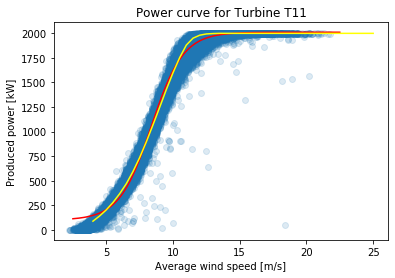

In [7]:
plt.scatter(signals_T11.Amb_WindSpeed_Avg, signals_T11.Grd_Prod_Pwr_Avg, alpha=0.15)
plt.plot(np.linspace(2.5, 22.5, 1000), power_curve(np.linspace(2.5, 22.5, 1000)), color="red")
plt.plot(Power_curve, color='yellow')
plt.xlabel("Average wind speed [m/s]")
plt.ylabel("Produced power [kW]")
plt.title("Power curve for Turbine T11")
plt.show()

Trochę się czerwony (przybliżenie sigmoidą) i żółty (power curve z pliku) rozjeżdżają na zakrętach i dla niskich prądów.

Może przybliżenie liniowe?


In [8]:
# przycina dane do prędkości wiatru z zakresu lower-uper
def trim_wind(turbine, lower, uper):
    return turbine.loc[(turbine["Amb_WindSpeed_Avg"] < uper) & (turbine["Amb_WindSpeed_Avg"] > lower) , :]

In [9]:
# interpolacja liniowa względem Power_curve (działa dla wiatrów 4-25)
power_curve2 = interpolate.interp1d(Power_curve.index, Power_curve.iloc[:,0])

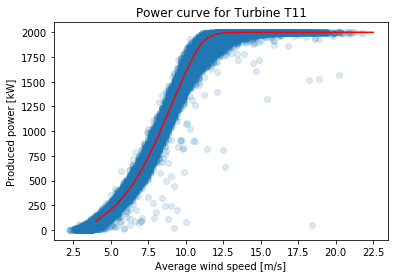

In [10]:
plt.scatter(signals_T11.Amb_WindSpeed_Avg, signals_T11.Grd_Prod_Pwr_Avg, alpha=0.15)
plt.plot(np.linspace(4, 22.5, 1000), power_curve2(np.linspace(4, 22.5, 1000)), color="red")
#plt.plot(Power_curve, color='yellow') # pokrywają się oczywiście XD
plt.xlabel("Average wind speed [m/s]")
plt.ylabel("Produced power [kW]")
plt.title("Power curve for Turbine T11")
plt.show()

Standaryzacja wg power_curve2

In [11]:
def std_power_curve2(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Std"] = turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] - power_curve2(turbine_new.loc[:,"Amb_WindSpeed_Avg"])
    return turbine_new

def std_power_curve(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Sigm"] = turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] - power_curve(turbine_new.loc[:,"Amb_WindSpeed_Avg"])
    return turbine_new

In [12]:
signals_T01_std = std_power_curve2(signals_T01)
signals_T06_std = std_power_curve2(signals_T06)
signals_T07_std = std_power_curve2(signals_T07)
signals_T09_std = std_power_curve2(signals_T09)
signals_T11_std = std_power_curve2(signals_T11)

signals_T01_std = std_power_curve(signals_T01_std)
signals_T06_std = std_power_curve(signals_T06_std)
signals_T07_std = std_power_curve(signals_T07_std)
signals_T09_std = std_power_curve(signals_T09_std)
signals_T11_std = std_power_curve(signals_T11_std)

C:\Users\agata\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\agata\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


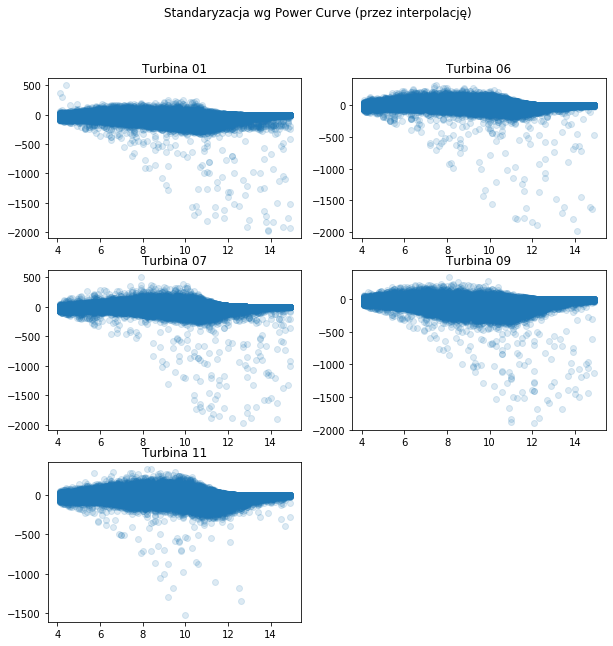

In [13]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve (przez interpolację)')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Std, alpha=0.15)
ax[0,0].set_title("Turbina 01")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Std, alpha=0.15)
ax[0,1].set_title("Turbina 06")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Std, alpha=0.15)
ax[1,0].set_title("Turbina 07")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Std, alpha=0.15)
ax[1,1].set_title("Turbina 09")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Std, alpha=0.15)
ax[2,0].set_title("Turbina 11")

ax[2,1].set_axis_off()
plt.show()

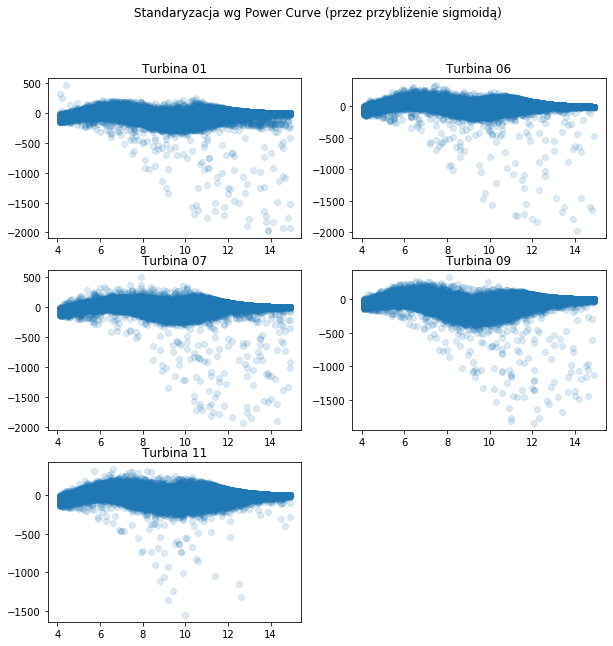

In [14]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve (przez przybliżenie sigmoidą)')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Sigm, alpha=0.15)
ax[0,0].set_title("Turbina 01")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Sigm, alpha=0.15)
ax[0,1].set_title("Turbina 06")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Sigm, alpha=0.15)
ax[1,0].set_title("Turbina 07")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Sigm, alpha=0.15)
ax[1,1].set_title("Turbina 09")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Sigm, alpha=0.15)
ax[2,0].set_title("Turbina 11")

ax[2,1].set_axis_off()
plt.show()